In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit,njit
from numba.typed import List
from scipy.integrate import solve_ivp
exp=np.exp

@jit
def alpha_m (V):
    return -0.025*(V+40.)/( exp(-(V+40)/10) - 1.0 )
@jit
def beta_m(V):
    return exp(-(V+65)/18)
@jit
def mNa_inf(V):
    return alpha_m(V) / (alpha_m(V) + beta_m(V))
@jit
def tau_mNa(V):
    return 1 / (alpha_m(V) + beta_m(V))/5
@jit
def alpha_h(V):
    return 0.0175*exp(-(V+65)/20)
@jit
def beta_h(V):
    return 0.25/(1.0 + exp(-(V+35)/10) )
@jit
def hNa_inf(V):
    return alpha_h(V) / (alpha_h(V) + beta_h(V))
@jit
def tau_hNa (V):
    return 1 / (alpha_h(V) + beta_h(V))/5
Kdshift=10.0
@jit
def alpha_mKd(V):
    return 0.0025*(V+55.)/(1. - exp(-(V+55.)/10.))

@jit
def beta_mKd(V):
    return 0.03125*exp(-(V+65.)/80.)

@jit
def mKd_inf (V):
    return alpha_mKd(V-Kdshift) / (alpha_mKd(V-Kdshift) + beta_mKd(V-Kdshift))
@jit
def tau_mKd (V):
    return 1 / (alpha_mKd(V-Kdshift) + beta_mKd(V-Kdshift))/5 

@jit
def mA_inf (V):
    return 1/(1+exp(-(V+90)/8.5))
@jit
def tau_mA (V):
    return 0.37 + 1/(exp((V+35.82)/19.697)+exp((V+79.69)/-12.7))/5
@jit
def hA_inf (V):
    return 1/(1+exp((V+78)/6))

@jit
def tau_hA(V): # Inactivation time-constant
    if (V < -63):
        tau_hA = 1/(exp((V+46.05)/5)+exp((V+238.4)/-37.45))
    else:
        tau_hA = 19
    return tau_hA/5

@jit
def mKir_inf (V):
    return 1/(1+exp((V+97.9+10)/9.7))

# T-type Ca-current (mt=activation variable, ht=inactivation variable)
@jit
def mt_inf (V):
    return 1/(1+exp(-(V+57)/6.2)) # Activation function
@jit
def tau_mt (V):
    return 0.612 + 1/(exp(-(V+131.6)/16.7)+exp((V+16.8)/18.2)) # Activation time-constant
@jit
def ht_inf(V):
    return 1/(1+exp((V+81)/4.03))# Inactivation function
@jit
def tau_ht(V): # Inactivation time-constant
    if (V < -80):
        tau_ht = exp((V+467)/66.6)
    else:
        tau_ht = (exp(-(V+21.88)/10.2)+28)
    return tau_ht


# L-type Ca-current (mL=activation variable)
@jit
def mL_inf (V):
    return 1/(1+exp(-(V+55.)/3)) # Activation function
@jit
def tau_mL(V):
    return (72*exp(-(V+45.)**2/400)+6.)# Activation time-constant

# H-current (mH=activation variable)
@jit
def alpha_mH (V):
    return exp(-14.59-(0.086*V))
@jit
def beta_mH (V):
    return exp(-1.87+(0.0701*V))
@jit
def mH_inf (V):
    return  alpha_mH(V) /(alpha_mH(V) + beta_mH(V)) # Activation function
@jit 
def tau_mH (V):
    return 1/(alpha_mH(V) + beta_mH(V)) # Activation time-constant
@jit 
def heaviside (t):
    return (1+np.sign(t))/2
@jit 
def pulse (t,ti,tf):
    return heaviside(t-ti)-heaviside(t-tf)

sin=np.sin
pi=np.pi


In [2]:
@njit
def HM_ODE(t,u,p):
    # Parameters
    min_num=1e-50
    Iapp=p[0] # Amplitude of constant applied current
    I1=p[1] # Amplitude of first step input
    I2=p[2] # Amplitude of second step input
    ti1=p[3] # Starting time of first step input
    tf1=p[4] # Ending time of first step input
    ti2=p[5] # Starting time of second step input
    tf2=p[6] # Ending time of second step input
    gT=p[7] # T-type calcium current maximal conductance
    gKd=p[8]  # Delayed-rectifier potassium current maximal conductance
    gH=p[9] # H-current maximal conductance
    gNa=p[10] # Sodium current maximal conductance
    gA=p[11] # A-type potassium current maximal conductance
    gKir=p[12]  # Inward-rectifier potassium current maximal conductance
    gLeak=p[13] # Leak current maximal conductance
    gL=p[14] # L-type calcium current maximal conductance
    gKCa=p[15] # Calcium-activated potassium current maximal conductance
    C=p[16] # Membrane capacitance
    taunoise=p[18] # Cutoff frequency for low-pass filtered Gaussian noise
    Ain=p[19] # Amplitude of sinusoïdal inut
    Win=p[20] # Frequency of  sinusoïdal inut

    # Variables
    V=u[0] # Membrane potential
    mNa=u[1] # Sodium current activation
    hNa=u[2] # Sodium current inactivation
    mH=u[3] # H current activation
    mt=u[4] # T-type calcium current activation
    ht=u[5] # T-type calcium current inactivation
    mA=u[6] # A-type potassium current activation
    hA=u[7] # A-type potassium current inactivation
    mKd=u[8] # Delayed-rectifier potassium current activation
    mL=u[9] # L-type calcium current activation
    Ca=u[10] # Intracellular calcium concentration
    noise=u[11] # Input noise

    # ODEs
    du1=1/C*(- gNa*mNa**3*hNa*(V-VNa) - gH*mH*(V-VH) - gT*mt**2*ht*(V-VCa) - gA*mA**4*hA*(V-VK) - gKd*mKd**4*(V-VK) -
                gKir*mKir_inf(V)*(V-VK) - gLeak*(V-Vleak)- gL*mL*(V-VCa) - gKCa*(Ca/(15.0+Ca))**4*(V-VK) +
                Iapp + I1*pulse(t,ti1,tf1) + I2*pulse(t,ti2,tf2) + noise + Ain*sin(2*pi*Win*t)) # Voltage equation
    du2=np.sign(tau_mNa(V))/max(np.absolute(tau_mNa(V)),min_num)*(-mNa+mNa_inf(V)) # gating equation
    du3=np.sign(tau_hNa(V))/max(np.absolute(tau_hNa(V)),min_num)*(-hNa+hNa_inf(V))
    du4=np.sign(tau_mH(V))/max(np.absolute(tau_mH(V)),min_num)*(-mH+mH_inf(V))
    du5=np.sign(tau_mt(V))/max(np.absolute(tau_mt(V)),min_num)*(-mt+mt_inf(V))
    du6=np.sign(tau_ht(V))/max(np.absolute(tau_ht(V)),min_num)*(-ht+ht_inf(V))
    du7=np.sign(tau_mA(V))/max(np.absolute(tau_mA(V)),min_num)*(-mA+mA_inf(V))
    du8=np.sign(tau_hA(V))/max(np.absolute(tau_hA(V)),min_num)*(-hA+hA_inf(V))
    du9=np.sign(tau_mKd(V))/max(np.absolute(tau_mKd(V)),min_num)*(-mKd+mKd_inf(V))
    du10=np.sign(tau_mL(V))/max(np.absolute(tau_mL(V)),min_num)*(-mL+mL_inf(V))
    du11=(-0.1*(gL*mL*(V-VCa))-0.01*Ca)/4 # Variation of intracellular calcium concentration
    du12=-noise/taunoise # Noise equation
    
    return [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12]

In [24]:
@njit
def  OB_ODE(t,u,p):
    min_num=1e-50
#     it=iter(u)
#     dinamics,Theta,phi,P_,u_sys=[[next(it) for _ in range(size)] for size in variable_size]
    
#     V,mNa,hNa,mH,mt,ht,mA,hA,mKd,mL,Ca,noise=dinamics
    
    V,mNa,hNa,mH,mt,ht,mA,hA,mKd,mL,Ca,noise=u[0:pos_dinamics]
    
    u_sys=u[pos_p:pos_u_sys]
    P=u[pos_phi:pos_p].reshape(num_phi,num_phi)
    Theta=u[pos_dinamics:pos_Theta]
    phi=u[pos_Theta:pos_phi]
    
    obesV=u_sys[0]
    
    
    Iapp=p[0] # Amplitude of constant applied current
    I1=p[1] # Amplitude of first step input
    I2=p[2] # Amplitude of second step input
    ti1=p[3] # Starting time of first step input
    tf1=p[4] # Ending time of first step input
    ti2=p[5] # Starting time of second step input
    tf2=p[6] # Ending time of second step input
    gT=p[7] # T-type calcium current maximal conductance
    gKd=p[8]  # Delayed-rectifier potassium current maximal conductance
    gH=p[9] # H-current maximal conductance
    gNa=p[10] # Sodium current maximal conductance
    gA=p[11] # A-type potassium current maximal conductance
    gKir=p[12]  # Inward-rectifier potassium current maximal conductance
    gLeak=p[13] # Leak current maximal conductance
    gL=p[14] # L-type calcium current maximal conductance
    gKCa=p[15] # Calcium-activated potassium current maximal conductance
    C=p[16] # Membrane capacitance
    taunoise=p[18] # Cutoff frequency for low-pass filtered Gaussian noise
    Ain=p[19] # Amplitude of sinusoïdal inut
    Win=p[20] # Frequency of  sinusoïdal inut
    
    
    PHI0= -mNa**3*hNa*(obesV-VNa) 
    PHI1= -mH*(obesV-VH)
    PHI2= -mt**2*ht*(obesV-VCa)
    PHI3= -mA**4*hA*(obesV-VK)
    PHI4= - mKd**4*(obesV-VK)
    PHI5= -mKir_inf(obesV)*(obesV-VK)
    PHI6= -(obesV-Vleak)
    PHI7= -mL*(obesV-VCa)
    PHI8= -(Ca/(15.0+Ca))**4*(obesV-VK)
    Current_in= Iapp + I1*pulse(t,ti1,tf1) + I2*pulse(t,ti2,tf2)+ Ain*sin(2*pi*Win*t)
    
    
    PHI= np.array([PHI0,PHI1,PHI2,PHI3,PHI4,PHI5,PHI6,PHI7,PHI8])
    
    #ODEs
    
    du1=1/C*(np.dot(PHI,Theta) + Current_in)+ gamma*(obesV-V)+gamma*np.dot(np.dot(phi,P),phi)*(obesV-V)# Voltage equation
    
    du2=np.sign(tau_mNa(obesV))/max(np.absolute(tau_mNa(obesV)),min_num)*(-mNa+mNa_inf(obesV)) # gating equation
    du3=np.sign(tau_hNa(obesV))/max(np.absolute(tau_hNa(obesV)),min_num)*(-hNa+hNa_inf(obesV))
    du4=np.sign(tau_mH(obesV))/max(np.absolute(tau_mH(obesV)),min_num)*(-mH+mH_inf(obesV))
    du5=np.sign(tau_mt(obesV))/max(np.absolute(tau_mt(obesV)),min_num)*(-mt+mt_inf(obesV))
    du6=np.sign(tau_ht(obesV))/max(np.absolute(tau_ht(obesV)),min_num)*(-ht+ht_inf(obesV))
    du7=np.sign(tau_mA(obesV))/max(np.absolute(tau_mA(obesV)),min_num)*(-mA+mA_inf(obesV))
    du8=np.sign(tau_hA(obesV))/max(np.absolute(tau_hA(obesV)),min_num)*(-hA+hA_inf(obesV))
    du9=np.sign(tau_mKd(obesV))/max(np.absolute(tau_mKd(obesV)),min_num)*(-mKd+mKd_inf(obesV))
    du10=np.sign(tau_mL(obesV))/max(np.absolute(tau_mL(obesV)),min_num)*(-mL+mL_inf(obesV))
    du11=(-0.1*(Theta[7]*mL*(obesV-VCa))-0.01*Ca)/4 # Variation of intracellular calcium concentration
    du12=-noise/taunoise # Noise equation
    
    du13=gamma_mask*np.dot(P,phi)*(obesV-V)
    
    du14=mask*(-gamma*phi+PHI)
    #du14=(np.absolute(du14)>min_num)*du14
    
    du15=alpha*P-np.dot(np.dot(P,np.outer(phi,phi)),P)
    
    du16=HM_ODE(t,u_sys,p)
    
    
    return [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12],du13,du14,du15.flatten(),du16

def  OB_ODE2(t,u,p):
    a,b,c,d,e= OB_ODE(t,u,p)
    out=[*a,*b,*c,*d,*e]
        
    out=np.nan_to_num(out)
        
    return (out)

In [25]:
num_dinamics=12
num_Theta=9
num_phi=num_Theta
num_p=num_Theta**2
num_u_sys=12
num_parameter=num_dinamics+num_Theta+num_phi+num_p+num_u_sys
model_output=num_dinamics+num_Theta+num_phi+num_p+1
variable_size=[num_dinamics,num_Theta,num_phi,num_p,num_u_sys]

pos_dinamics=num_dinamics
pos_Theta=pos_dinamics+num_Theta
pos_phi=pos_Theta+num_phi
pos_p=pos_phi+num_p
pos_u_sys=pos_p+num_u_sys

In [26]:
#Test observer
## Simulation of the model in current-clamp mode

## Definition of reversal potential values. 
VNa = 45.; # Sodium reversal potential
VCa = 120.; # Calcium reversal potential
VK = -90.; # Potassium reversal potential
VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions)
Vleak = -55.; # Reversal potential of leak channels

## Definition of membrane capacitance and maximal conductance values. 
C=0.1; # Membrane capacitance
gLeak=0.1; # Leak current maximal conductance
gNa=120.; # Sodium current maximal conductance
gKd=80.; # Delayed-rectifier potassium current maximal conductance
gA=0.; # A-type potassium current maximal conductance
gKir=0.; # Inward-rectifier potassium current maximal conductance
gT=2.; # T-type calcium current maximal conductance
gH=0.1; # H-current maximal conductance
gL=0.4; # L-type calcium current maximal conductance
gKCa=2.; # Calcium-activated potassium current maximal conductance

## Definition of simulation time.
Tfinal=10000.0
tspan=[0.0,Tfinal]

## Input current defition
# Constant current
Iapp=0.

# Current pulses
I1=0.# Amplitude of first pulse
ti1=0. # Starting time of first pulse
tf1=200. # Ending time of first pulse
I2=0. # Amplitude of second pulse
ti2=200. # Starting time of second pulse
tf2=600. # Ending time of first pulse

# Sinusoidal input
Ain=2.5# Amplitude
Win=0.5 # Frequency

#Hyperparameters
gamma=10
variable_mask=np.array([1,1,1,1,1,1,1,1,1])*1.0
mask=np.array([1,1,1,1,1,1,1,1,1])*1.0 #freeze variable by setting 0 in the mask
gamma_mask=mask*gamma
variable_alpha=np.array([1,1,1,1,1,1,1,1,1])*1.0
alpha=0.005
#alpha[0,0]=0.1

# Input noise
NoiseIN=0. # Amplitude
TauNoise=2.0 # Cut-off frequency

## Current-clamp experiment
# Parameter vector for simulations
p=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,C,NoiseIN,TauNoise,Ain,Win]

# Initial conditions
V0= -70.
x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10.*gL*mL_inf(V0)*(V0-VCa), 0.0]

"""
du2=1/tau_mNa(V)*(-mNa+mNa_inf(V)) 
    du3=1/tau_hNa(V)*(-hNa+hNa_inf(V))
    du4=1/tau_mH(V)*(-mH+mH_inf(V))
    du5=1/tau_mt(V)*(-mt+mt_inf(V))
    du6=1/tau_ht(V)*(-ht+ht_inf(V))
    du7=1/tau_mA(V)*(-mA+mA_inf(V))
    du8=1/tau_hA(V)*(-hA+hA_inf(V))
    du9=1/tau_mKd(V)*(-mKd+mKd_inf(V))
    du10=1/tau_mL(V)*(-mL+mL_inf(V))
    du11=(-0.1*(gL*mL*(V-VCa))-0.01*Ca)/4 
"""
'''[ 'Na','H','t','A','K','Kir','leak','L','KCa']
    120,0.1,2,0,80,0,0.1,0.4,2
[1.20078309e+02 9.99935030e-02 2.00543802e+00 3.67723634e-06
 8.01004533e+01 0.00000000e+00 1.00000000e-01 3.99355255e-01
 2.00000000e+00]
 [1.19244440e+02 1.07155203e-01 1.97335159e+00 9.41065469e-04
 7.94144652e+01 0.00000000e+00 9.92878415e-02 4.02652110e-01
 2.00000000e+00]
 [ 1.19013827e+02  1.08252336e-01  1.97016712e+00 -1.99602367e-03
  7.92679611e+01  6.14319636e-03  9.91735126e-02  4.02071713e-01
  2.00000000e+00]
  random result:without kca
  [ 1.17175982e+02  1.04500391e-01  1.92046277e+00 -5.58087699e-03
  7.79309064e+01  1.20699524e-02  9.95532125e-02  4.04948400e-01
  2.00000000e+00]
  random result:
  [ 1.19999126e+02  1.00004794e-01  1.99996145e+00 -2.65651809e-07
  7.99992936e+01 -3.46322090e-07  9.99991554e-02  4.00004375e-01
  2.00000076e+00]
  [ 1.19999422e+02  1.00005059e-01  1.99997393e+00 -2.91592737e-07
  7.99995340e+01 -5.14970360e-07  9.99991061e-02  4.00003699e-01
  2.00000085e+00]
 
'''
#Theta0=(np.array([50,0,0,0,70,0,0.1,0,0])).tolist()
Theta0= np.random.rand(9)*100.
#Theta0[7]=0.4
print(Theta0)
A0=(np.ones(num_Theta)*0.1).tolist()*variable_mask
P0=np.diag(np.diag(np.outer(A0,A0))).flatten().tolist()
V0= - np.random.rand(1)*100.
x0_ = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10.*gL*mL_inf(V0)*(V0-VCa), 0.0]
#P0[-1]=0
X0_=[*x0_,*Theta0,*A0,*P0,*x0]
print(len(X0_))
print(len(Theta0))

[ 1.56346289 85.69785275 32.75007197 47.13260212 51.71986896 10.84614551
  7.77465855 33.73172123 14.73104532]
123
9


In [27]:
sol=solve_ivp(OB_ODE2,tspan , X0_,args=[p])

C:\Users\lenovo\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\lenovo\anaconda3\lib\site-packages\numba\core\ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'p' of function 'OB_ODE'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "C:\Users\lenovo\AppData\Local\Temp\ipykernel_22984\3760984280.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
C:\Users\lenovo\anaconda3\lib\site-packages\num

Text(0.5, 0, 'time')

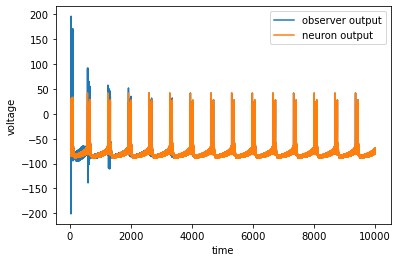

In [28]:
#plot result
fig=plt.figure()
plt.plot(sol.t[1000:],sol.y[0][1000:],label='observer output')
plt.plot(sol.t[1000:],sol.y[111][1000:],label='neuron output')
plt.legend()
plt.ylabel('voltage')
plt.xlabel('time')


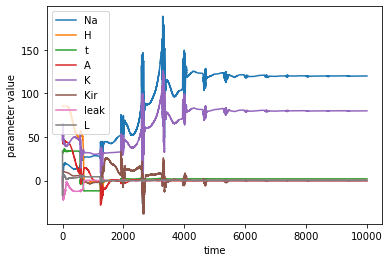

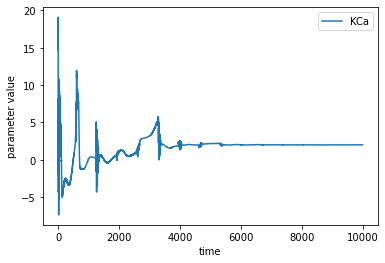

[120.08805169825055 0.09926854543730398 2.001204357848025
 0.0002593176926639212 80.0525107579656 -0.00030014587858845875
 0.10020686578610151 0.4002461029814285 2.005732881917856]


In [29]:
#plot parameters
fig=plt.figure()
labels=[ 'Na','H','t','A','K','Kir','leak','L']
for i in range(num_Theta-1):
    plt.plot(sol.t,sol.y[12+i],label=labels[i])
plt.legend()
plt.ylabel('parameter value')
plt.xlabel('time')
fig.savefig('single_redundant_neuron_parameter.jpg')
plt.show()

fig=plt.figure()
plt.plot(sol.t,sol.y[12+num_Theta-1],label='KCa')
plt.legend()
plt.ylabel('parameter value')
plt.xlabel('time')
fig.savefig('single_redundant_neuron_KCa.jpg')
plt.show()
print(sol.y[12:12+num_Theta,-1])

In [4]:
#Test real model
## Simulation of the model in current-clamp mode

## Definition of reversal potential values. 
VNa = 45; # Sodium reversal potential 45
VCa = 120.; # Calcium reversal potential
VK = -90.; # Potassium reversal potential -90
VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
Vleak = -55.; # Reversal potential of leak channels

## Definition of membrane capacitance and maximal conductance values. 
C=0.1; # Membrane capacitance
gLeak=0.1; # Leak current maximal conductance
gNa=120.; # Sodium current maximal conductance
gKd=30; # Delayed-rectifier potassium current maximal conductance
gA=0.; # A-type potassium current maximal conductance
gKir=0.; # Inward-rectifier potassium current maximal conductance
gT=0.; # T-type calcium current maximal conductance
gH=0.; # H-current maximal conductance
gL=0.; # L-type calcium current maximal conductance
gKCa=30.; # Calcium-activated potassium current maximal conductance

## Definition of simulation time.
Tfinal=300.0
tspan=[0.0,Tfinal]

## Input current defition
# Constant current
Iapp=2.5

# Current pulses
I1=0. # Amplitude of first pulse
ti1=0. # Starting time of first pulse
tf1=50. # Ending time of first pulse
I2=0. # Amplitude of second pulse
ti2=50. # Starting time of second pulse
tf2=150. # Ending time of first pulse

# Sinusoidal input
Ain=0. # Amplitude
Win=0.5 # Frequency

# Input noise
NoiseIN=0. # Amplitude
TauNoise=2.0 # Cut-off frequency

## Current-clamp experiment
# Parameter vector for simulations
p1=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,C,NoiseIN,TauNoise,Ain,Win]
p= List()
[p.append(x) for x in p1]
# Initial conditions
V0= -60.
x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), 0.0]

In [109]:
import time
t0= time.clock()
sol=solve_ivp(HM_ODE ,tspan , x0,args=[p])
t1 = time.clock() - t0
print("Time elapsed: ", t1)

C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


Time elapsed:  1.6948298000002069


C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


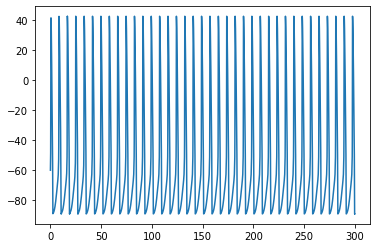

In [110]:
plt.plot(sol.t, sol.y[0])

In [6]:
num_dinamics=12
num_Theta=9
num_phi=num_Theta
num_p=num_Theta**2
num_u_sys=12
num_parameter=num_dinamics+num_Theta+num_phi+num_p+num_u_sys
model_output=num_dinamics+num_Theta+num_phi+num_p+1
variable_size=[num_dinamics,num_Theta,num_phi,num_p,num_u_sys]

pos_dinamics=num_dinamics
pos_Theta=pos_dinamics+num_Theta
pos_phi=pos_Theta+num_phi
pos_p=pos_phi+num_p
pos_u_sys=pos_p+num_u_sys

In [7]:
#Test observer
## Simulation of the model in current-clamp mode

## Definition of reversal potential values. 
VNa = 45.; # Sodium reversal potential
VCa = 120.; # Calcium reversal potential
VK = -90.; # Potassium reversal potential
VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions)
Vleak = -55.; # Reversal potential of leak channels

## Definition of membrane capacitance and maximal conductance values. 
C=0.1; # Membrane capacitance
gLeak=0.1; # Leak current maximal conductance
gNa=120.; # Sodium current maximal conductance
gKd=30.; # Delayed-rectifier potassium current maximal conductance
gA=0.; # A-type potassium current maximal conductance
gKir=0.; # Inward-rectifier potassium current maximal conductance
gT=0.; # T-type calcium current maximal conductance
gH=0.0; # H-current maximal conductance
gL=0.0; # L-type calcium current maximal conductance
gKCa=0.; # Calcium-activated potassium current maximal conductance

## Definition of simulation time.
Tfinal=3000.0
tspan=[0.0,Tfinal]

## Input current defition
# Constant current
Iapp=0.

# Current pulses
I1=0.# Amplitude of first pulse
ti1=0. # Starting time of first pulse
tf1=200. # Ending time of first pulse
I2=0. # Amplitude of second pulse
ti2=200. # Starting time of second pulse
tf2=600. # Ending time of first pulse

# Sinusoidal input
Ain=2.5# Amplitude
Win=0.5# Frequency

#Hyperparameters
gamma=10
variable_mask=np.array([1,1,1,1,1,1,1,1,1])
mask=np.array([1,1,1,1,1,1,1,1,1]) #freeze variable by setting 0 in the mask
gamma_mask=mask*gamma
variable_alpha=np.array([1,1,1,1,1,1,1,1,1])
alpha=0.005
#alpha[0,0]=0.1

# Input noise
NoiseIN=0.0 # Amplitude
TauNoise=2.0 # Cut-off frequency

## Current-clamp experiment
# Parameter vector for simulations
p1=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,C,NoiseIN,TauNoise,Ain,Win]
p= List()
[p.append(x) for x in p1]

# Initial conditions
V0= -70.
x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), 0.0]

"""
du2=1/tau_mNa(V)*(-mNa+mNa_inf(V)) 
    du3=1/tau_hNa(V)*(-hNa+hNa_inf(V))
    du4=1/tau_mH(V)*(-mH+mH_inf(V))
    du5=1/tau_mt(V)*(-mt+mt_inf(V))
    du6=1/tau_ht(V)*(-ht+ht_inf(V))
    du7=1/tau_mA(V)*(-mA+mA_inf(V))
    du8=1/tau_hA(V)*(-hA+hA_inf(V))
    du9=1/tau_mKd(V)*(-mKd+mKd_inf(V))
    du10=1/tau_mL(V)*(-mL+mL_inf(V))
    du11=(-0.1*(gL*mL*(V-VCa))-0.01*Ca)/4 
"""
'''[ 'Na','H','t','A','K','Kir','leak','L','KCa']
    120,0.1,2,0,80,0,0.1,0.4,2
[1.20078309e+02 9.99935030e-02 2.00543802e+00 3.67723634e-06
 8.01004533e+01 0.00000000e+00 1.00000000e-01 3.99355255e-01
 2.00000000e+00]
 [1.19244440e+02 1.07155203e-01 1.97335159e+00 9.41065469e-04
 7.94144652e+01 0.00000000e+00 9.92878415e-02 4.02652110e-01
 2.00000000e+00]
 [ 1.19013827e+02  1.08252336e-01  1.97016712e+00 -1.99602367e-03
  7.92679611e+01  6.14319636e-03  9.91735126e-02  4.02071713e-01
  2.00000000e+00]
  random result:without kca
  [ 1.17175982e+02  1.04500391e-01  1.92046277e+00 -5.58087699e-03
  7.79309064e+01  1.20699524e-02  9.95532125e-02  4.04948400e-01
  2.00000000e+00]
  random result:
  [ 1.19999126e+02  1.00004794e-01  1.99996145e+00 -2.65651809e-07
  7.99992936e+01 -3.46322090e-07  9.99991554e-02  4.00004375e-01
  2.00000076e+00]
  [ 1.19999422e+02  1.00005059e-01  1.99997393e+00 -2.91592737e-07
  7.99995340e+01 -5.14970360e-07  9.99991061e-02  4.00003699e-01
  2.00000085e+00]
 
'''
#Theta0=(np.array([50,0,0,0,70,0,0.1,0,0])).tolist()
Theta0= np.random.rand(9)*100
#Theta0[7]=0.4
print(Theta0)
A0=(np.ones(num_Theta)*0.1).tolist()*variable_mask
P0=np.diag(np.diag(np.outer(A0,A0))).flatten().tolist()
#P0[-1]=0
V0= - np.random.rand(1)*100
x0_ = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), 0.0]
X0_=[*x0_,*Theta0,*A0,*P0,*x0]
print(len(X0_))
print(len(Theta0))

[81.12875138 20.51460936  1.22858389 53.41776143 34.8458811  62.98122764
 42.04287581 30.05057863 21.53001813]
123
9


In [8]:
print(variable_size)

[12, 9, 9, 81, 12]


In [9]:
sol=solve_ivp(OB_ODE2,tspan , X0_,args=[p])

C:\Users\lenovo\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\lenovo\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


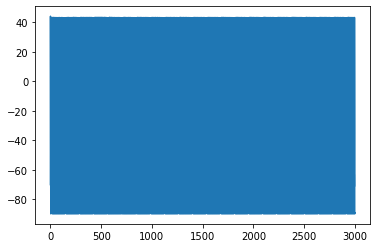

In [115]:
plt.plot(sol.t,sol.y[111],label='neuron output')

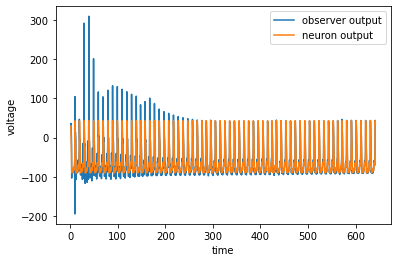

In [10]:
#plot result
fig=plt.figure()
plt.plot(sol.t[100:15000],sol.y[0][100:15000],label='observer output')
plt.plot(sol.t[100:15000],sol.y[111][100:15000],label='neuron output')
plt.legend()
plt.ylabel('voltage')
plt.xlabel('time')
fig.savefig('single_redundant_neuron.jpg')

In [ ]:
fig=plt.figure()
plt.plot(sol.t[100:15000],sol.y[0][100:15000],label='observer output')
#plt.plot(sol.t[100:15000],sol.y[111][100:15000],label='neuron output')
plt.legend()
plt.axis('off')
fig.savefig('observer_noaxis.jpg')

C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if __name__ == '__main__':
C:\Users\lenovo\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


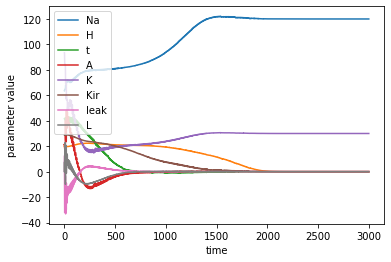

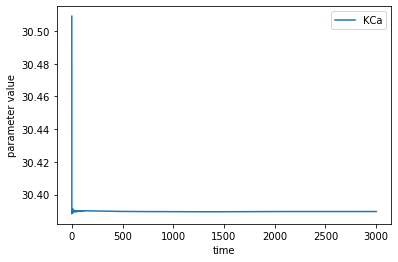

[119.99999999479012 3.808440279627065e-09 3.8299186757877296e-10
 -1.305625931649691e-10 29.999999998701256 1.3955504309136994e-09
 0.10000000003350848 -1.2336442726912459e-10 30.38961058751138]


In [171]:
#plot parameters
fig=plt.figure()
labels=[ 'Na','H','t','A','K','Kir','leak','L']
for i in range(num_Theta-1):
    plt.plot(sol.t,sol.y[12+i],label=labels[i])
plt.legend()
plt.ylabel('parameter value')
plt.xlabel('time')
fig.savefig('single_redundant_neuron_parameter.jpg')
plt.show()

fig=plt.figure()
plt.plot(sol.t,sol.y[12+num_Theta-1],label='KCa')
plt.legend()
plt.ylabel('parameter value')
plt.xlabel('time')
fig.savefig('single_redundant_neuron_KCa.jpg')
plt.show()
print(sol.y[12:12+num_Theta,-1])

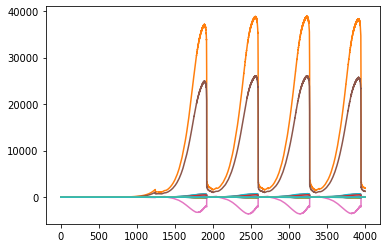

In [30]:
plt.figure()
for i in range(30):
    plt.plot(sol.t,sol.y[29+i])
plt.show()

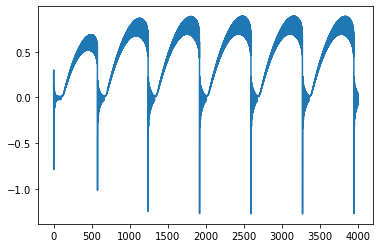

In [31]:
plt.plot(sol.t,sol.y[22])

In [248]:
#Test observer
## Simulation of the model in current-clamp mode

## Definition of reversal potential values. 
VNa = 45.; # Sodium reversal potential
VCa = 120.; # Calcium reversal potential
VK = -90.; # Potassium reversal potential
VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions)
Vleak = -55.; # Reversal potential of leak channels

## Definition of membrane capacitance and maximal conductance values. 
C=0.1; # Membrane capacitance
gLeak=0.1; # Leak current maximal conductance

gNa=120.; # Sodium current maximal conductance 120
gKd=30; # Delayed-rectifier potassium current maximal conductance 80
gT=0; # T-type calcium current maximal conductance 2.
gH=0; # H-current maximal conductance 0.1
gL=0; # L-type calcium current maximal conductance 0.4
gKCa=0; # Calcium-activated potassium current maximal conductance 2.
gA=0.; # A-type potassium current maximal conductance
gKir=0.; # Inward-rectifier potassium current maximal conductance

## Definition of simulation time.
Tfinal=1000.0
tspan=[0.0,Tfinal]

## Input current defition
# Constant current
Iapp=0

# Current pulses
I1=2.5# Amplitude of first pulse
ti1=0 # Starting time of first pulse
tf1=200 # Ending time of first pulse
I2=-2.5 # Amplitude of second pulse
ti2=200 # Starting time of second pulse
tf2=600 # Ending time of first pulse

# Sinusoidal input
Ain=0# Amplitude
Win=0.5 # Frequency

#Hyperparameters
gamma=10
variable_mask=np.array([1,0,0,0,1,0,0,0,0])
mask=np.array([1,0,0,0,1,0,0,0,0]) #freeze variable by setting 0 in the mask
gamma_mask=mask*gamma
variable_alpha=np.array([0.2,0,0,0,0.1,0,0,0,0])
alpha=np.outer(variable_alpha,variable_alpha)

# Input noise
NoiseIN=0. # Amplitude
TauNoise=2.0 # Cut-off frequency

## Current-clamp experiment
# Parameter vector for simulations
p=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,C,NoiseIN,TauNoise,Ain,Win]

# Initial conditions
V0= -70.
x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), 0.0]

"""
du2=1/tau_mNa(V)*(-mNa+mNa_inf(V)) 
    du3=1/tau_hNa(V)*(-hNa+hNa_inf(V))
    du4=1/tau_mH(V)*(-mH+mH_inf(V))
    du5=1/tau_mt(V)*(-mt+mt_inf(V))
    du6=1/tau_ht(V)*(-ht+ht_inf(V))
    du7=1/tau_mA(V)*(-mA+mA_inf(V))
    du8=1/tau_hA(V)*(-hA+hA_inf(V))
    du9=1/tau_mKd(V)*(-mKd+mKd_inf(V))
    du10=1/tau_mL(V)*(-mL+mL_inf(V))
    du11=(-0.1*(gL*mL*(V-VCa))-0.01*Ca)/4 
"""
'''[ 'Na','H','t','A','K','Kir','leak','L','KCa']
    120,0.1,2,0,80,0,0.1,0.4,2
[1.20078309e+02 9.99935030e-02 2.00543802e+00 3.67723634e-06
 8.01004533e+01 0.00000000e+00 1.00000000e-01 3.99355255e-01
 2.00000000e+00]
 [1.19244440e+02 1.07155203e-01 1.97335159e+00 9.41065469e-04
 7.94144652e+01 0.00000000e+00 9.92878415e-02 4.02652110e-01
 2.00000000e+00]
 [ 1.19013827e+02  1.08252336e-01  1.97016712e+00 -1.99602367e-03
  7.92679611e+01  6.14319636e-03  9.91735126e-02  4.02071713e-01
  2.00000000e+00]
  random result:without kca
  [ 1.17175982e+02  1.04500391e-01  1.92046277e+00 -5.58087699e-03
  7.79309064e+01  1.20699524e-02  9.95532125e-02  4.04948400e-01
  2.00000000e+00]
  random result:
  [ 1.19999126e+02  1.00004794e-01  1.99996145e+00 -2.65651809e-07
  7.99992936e+01 -3.46322090e-07  9.99991554e-02  4.00004375e-01
  2.00000076e+00]
  [ 1.19999422e+02  1.00005059e-01  1.99997393e+00 -2.91592737e-07
  7.99995340e+01 -5.14970360e-07  9.99991061e-02  4.00003699e-01
  2.00000085e+00]
 
'''
Theta0=(np.array([50,0,0,0,70,0,0.1,0,0])).tolist()
#Theta0= np.random.rand(9)*100
#Theta0[7]=0.4
print(Theta0)
A0=(np.ones(num_Theta)*0.1).tolist()*variable_mask
P0=np.diag(np.diag(np.outer(A0,A0))).flatten().tolist()
#P0[-1]=0
X0_=[*x0,*Theta0,*A0,*P0,*x0]
print(len(X0_))
print(len(Theta0))

[50.0, 0.0, 0.0, 0.0, 70.0, 0.0, 0.1, 0.0, 0.0]
123
9


In [249]:
sol=solve_ivp(OB_ODE2,tspan , X0_)

C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:101: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: overflow encountered in double_scalars
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launc

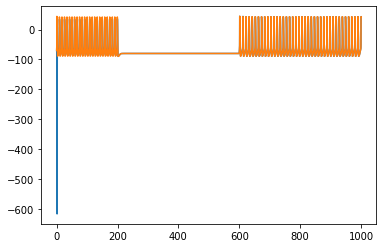

In [250]:
#plot result
plt.plot(sol.t,sol.y[0])
plt.plot(sol.t,sol.y[111])

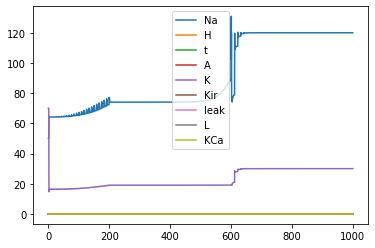

[1.2e+02 0.0e+00 0.0e+00 0.0e+00 3.0e+01 0.0e+00 1.0e-01 0.0e+00 0.0e+00]


In [251]:
#plot parameters
labels=[ 'Na','H','t','A','K','Kir','leak','L','KCa']
plt.figure()
for i in range(num_Theta):
    plt.plot(sol.t,sol.y[12+i],label=labels[i])
plt.legend()
plt.show()
print(sol.y[12:12+num_Theta,-1])

In [258]:
#Test observer
## Simulation of the model in current-clamp mode

## Definition of reversal potential values. 
VNa = 45.; # Sodium reversal potential
VCa = 120.; # Calcium reversal potential
VK = -90.; # Potassium reversal potential
VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions)
Vleak = -55.; # Reversal potential of leak channels

## Definition of membrane capacitance and maximal conductance values. 
C=0.1; # Membrane capacitance
gLeak=0.1; # Leak current maximal conductance

gNa=120.; # Sodium current maximal conductance 120
gKd=30; # Delayed-rectifier potassium current maximal conductance 80
gT=0; # T-type calcium current maximal conductance 2.
gH=0; # H-current maximal conductance 0.1
gL=0; # L-type calcium current maximal conductance 0.4
gKCa=0; # Calcium-activated potassium current maximal conductance 2.
gA=0.; # A-type potassium current maximal conductance
gKir=0.; # Inward-rectifier potassium current maximal conductance

## Definition of simulation time.
Tfinal=1000.0
tspan=[0.0,Tfinal]

## Input current defition
# Constant current
Iapp=0

# Current pulses
I1=2.5# Amplitude of first pulse
ti1=0 # Starting time of first pulse
tf1=200 # Ending time of first pulse
I2=-2.5 # Amplitude of second pulse
ti2=200 # Starting time of second pulse
tf2=600 # Ending time of first pulse

# Sinusoidal input
Ain=0# Amplitude
Win=0.5 # Frequency

#Hyperparameters
gamma=10
variable_mask=np.array([1,0,0,0,1,0,0,0,0])
mask=np.array([1,0,0,0,1,0,0,0,0]) #freeze variable by setting 0 in the mask
gamma_mask=mask*gamma
variable_alpha=np.array([0.1,0,0,0,0.1,0,0,0,0])
alpha=np.outer(variable_alpha,variable_alpha)

# Input noise
NoiseIN=0. # Amplitude
TauNoise=2.0 # Cut-off frequency

## Current-clamp experiment
# Parameter vector for simulations
p=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,C,NoiseIN,TauNoise,Ain,Win]

# Initial conditions
V0= -70.
x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), 0.0]

"""
du2=1/tau_mNa(V)*(-mNa+mNa_inf(V)) 
    du3=1/tau_hNa(V)*(-hNa+hNa_inf(V))
    du4=1/tau_mH(V)*(-mH+mH_inf(V))
    du5=1/tau_mt(V)*(-mt+mt_inf(V))
    du6=1/tau_ht(V)*(-ht+ht_inf(V))
    du7=1/tau_mA(V)*(-mA+mA_inf(V))
    du8=1/tau_hA(V)*(-hA+hA_inf(V))
    du9=1/tau_mKd(V)*(-mKd+mKd_inf(V))
    du10=1/tau_mL(V)*(-mL+mL_inf(V))
    du11=(-0.1*(gL*mL*(V-VCa))-0.01*Ca)/4 
"""
'''[ 'Na','H','t','A','K','Kir','leak','L','KCa']
    120,0.1,2,0,80,0,0.1,0.4,2
[1.20078309e+02 9.99935030e-02 2.00543802e+00 3.67723634e-06
 8.01004533e+01 0.00000000e+00 1.00000000e-01 3.99355255e-01
 2.00000000e+00]
 [1.19244440e+02 1.07155203e-01 1.97335159e+00 9.41065469e-04
 7.94144652e+01 0.00000000e+00 9.92878415e-02 4.02652110e-01
 2.00000000e+00]
 [ 1.19013827e+02  1.08252336e-01  1.97016712e+00 -1.99602367e-03
  7.92679611e+01  6.14319636e-03  9.91735126e-02  4.02071713e-01
  2.00000000e+00]
  random result:without kca
  [ 1.17175982e+02  1.04500391e-01  1.92046277e+00 -5.58087699e-03
  7.79309064e+01  1.20699524e-02  9.95532125e-02  4.04948400e-01
  2.00000000e+00]
  random result:
  [ 1.19999126e+02  1.00004794e-01  1.99996145e+00 -2.65651809e-07
  7.99992936e+01 -3.46322090e-07  9.99991554e-02  4.00004375e-01
  2.00000076e+00]
  [ 1.19999422e+02  1.00005059e-01  1.99997393e+00 -2.91592737e-07
  7.99995340e+01 -5.14970360e-07  9.99991061e-02  4.00003699e-01
  2.00000085e+00]
 
'''
Theta0=(np.array([50,0,0,0,70,0,0.1,0,0])).tolist()
#Theta0= np.random.rand(9)*100
#Theta0[7]=0.4
print(Theta0)
A0=(np.ones(num_Theta)*0.1).tolist()*variable_mask
P0=np.diag(np.diag(np.outer(A0,A0))).flatten().tolist()
#P0[-1]=0
X0_=[*x0,*Theta0,*A0,*P0,*x0]
print(len(X0_))
print(len(Theta0))

[50.0, 0.0, 0.0, 0.0, 70.0, 0.0, 0.1, 0.0, 0.0]
123
9


In [259]:
sol=solve_ivp(OB_ODE2,tspan , X0_)

C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:101: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: overflow encountered in double_scalars
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launc

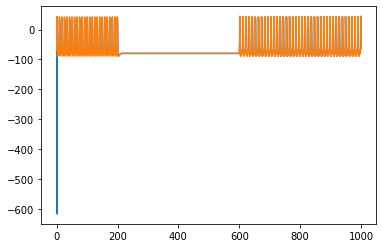

In [260]:
#plot result
plt.plot(sol.t,sol.y[0])
plt.plot(sol.t,sol.y[111])

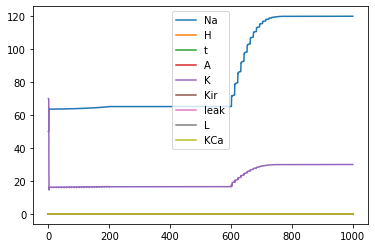

[1.2e+02 0.0e+00 0.0e+00 0.0e+00 3.0e+01 0.0e+00 1.0e-01 0.0e+00 0.0e+00]


In [261]:
#plot parameters
labels=[ 'Na','H','t','A','K','Kir','leak','L','KCa']
plt.figure()
for i in range(num_Theta):
    plt.plot(sol.t,sol.y[12+i],label=labels[i])
plt.legend()
plt.show()
print(sol.y[12:12+num_Theta,-1])

In [55]:
#Test real model
## Simulation of the model in current-clamp mode

## Definition of reversal potential values. 
VNa = 45; # Sodium reversal potential 45
VCa = 120.; # Calcium reversal potential
VK = -90.; # Potassium reversal potential -90
VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
Vleak = -55.; # Reversal potential of leak channels

## Definition of membrane capacitance and maximal conductance values. 
C=0.1; # Membrane capacitance


'''[ 'Na','H','t','A','K','Kir','leak','L','KCa']'''

'''[ 1.25128422e+02 -1.13945166e-01  9.71732068e-02  3.18964257e-02
  8.38095276e+01 -3.26635388e+00  6.06809185e-02  4.00000000e-01
  2.04578308e+00]'''

gNa,gH,gT,gA,gKd,gKir,gLeak,gL,gKCa= [82.31079191,  0.,          0. ,         0.   ,      20.57439108,  0.,
  0.1,         0.,          0.,        ]
#[65.2047134,  0., 0.,0.,16.3129626,  0, 0.1,0.,0.,]

## Definition of simulation time.
Tfinal=200.0
tspan=[0.0,Tfinal]

## Input current defition
# Constant current
Iapp=2.5

# Current pulses
I1=0. # Amplitude of first pulse
ti1=100 # Starting time of first pulse
tf1=103 # Ending time of first pulse
I2=0. # Amplitude of second pulse
ti2=200 # Starting time of second pulse
tf2=203 # Ending time of first pulse

# Sinusoidal input
Ain=0.0 # Amplitude
Win=0.0 # Frequency

# Input noise
NoiseIN=0. # Amplitude
TauNoise=2.0 # Cut-off frequency

## Current-clamp experiment
# Parameter vector for simulations
p=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,C,NoiseIN,TauNoise,Ain,Win]

# Initial conditions
V0= -60.
x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), 0.0]

In [56]:
sol=solve_ivp(HM_ODE ,tspan , x0)

C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
C:\Users\lenovo\anaconda3\lib\site-packages\scipy\integrate\_ivp\base.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  return np.asarray(fun(t, y), dtype=dtype)
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_laun

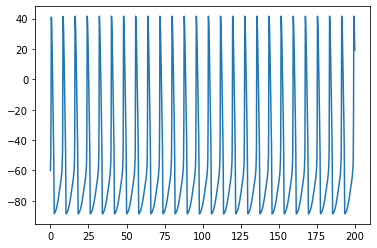

In [57]:
plt.plot(sol.t, sol.y[0])